<a href="https://colab.research.google.com/github/reneekuo95/Climate_Ledgerlings/blob/main/Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Functions for Cumulative RF (historical)

In [164]:
import numpy as np
from matplotlib import pyplot as plt
import statistics

cc_1_r=0.2173 #Box 1 emission share
cc_2_r=0.224 #Box 2 emission share
cc_3_r=0.2824 #Box 3 emission share
cc_4_r=0.2763 #Box 4 emission share
cc_2_t=394.4 #Box 2 lifetime
cc_3_t=36.54 #Box 3 lifetime
cc_4_t=4.304 #Box 4 lifetime

#Atmospheric lifetime:
CH4_t=11.8 #Methane
N2O_t=109 #Nitrous oxide

#Radiative efficiency (direct):
CO2_rf=0.0000133 #Carbon dioxide
CH4_rf=0.000388 #Methane
N2O_rf=0.0032 #Nitrous oxide

#Indirect / interaction effects:
CH4_O3=0.00014 #Methane - tropospheric O3
CH4_H2O=0.00004 #Methane - stratospheric H2O
N2O_O3=0.00055 #Nitrous oxide - stratospheric O3
N2O_CH4=-1.7 #Nitous oxide - CH4 lifetime

#Temperature model:
tm_Cs=7.7 #Eff. heat capacity surface layer
tm_Cd=147 #Eff. heat capacity deep layer
tm_e=1.03 #Efficacy of deep ocean heat uptake
tm_y=0.854368932038835 #Surface_deep ocean heat transfer
tm_a=-1.31 #Radiative damping (climate sensitivity)

#Carbon cycle feedback model:
ccf_g=11060000000 #Carbon temperature response
ccf_1_r=0.6368 #Box 1 outflux share
ccf_2_r=0.3322 #Box 2 outflux share
ccf_3_r=0.031 #Box 3 outflux share
ccf_1_t=2.376 #Box 1 lifetime
ccf_2_t=30.14 #Box 2 lifetime
ccf_3_t=490.1 #Box 3 lifetime

def calc_co2_rf(co2_emission_mt):
  # input is million tonnes, convert to tonnes
  emission_input = co2_emission_mt*10**6
  #print("co2 input",emission_input)
  carbon_calc_1 = [tuple(np.repeat(element, 4)) for element in emission_input]
  carbon_cycle_1 = np.array([cc_1_r,cc_2_r,cc_3_r,cc_4_r])
  b = carbon_calc_1 * carbon_cycle_1

  carbon_cycle_2 = np.array([1,np.exp(-1 / cc_2_t),np.exp(-1 / cc_3_t),np.exp(-1 / cc_4_t)])


  for i in range(emission_input.shape[0]-1):
    middle = b[i]*carbon_cycle_2
    b[i+1]=b[i+1]+middle

  stock = np.sum(b, axis=1)
  #print("stock")
  #print(stock)
  concentration = stock*10**-6*28.97/44.01*1/5.13252
  #print("concentration")
  #print(concentration)
  rf = concentration*CO2_rf*10**9

  #print("rf")
  #print(rf)

  agwp = rf
  agwp[0]=0
  for i in range (agwp.shape[0]-2):
    #print(i)
    agwp[i+1] = agwp[i]+(rf[i+1]+rf[i+2])/2

  agwp[agwp.shape[0]-1]=agwp[agwp.shape[0]-2]+rf[rf.shape[0]-1]
  #print("agwp :", agwp)

  co2_rf_result = agwp[agwp.shape[0]-1]*10**-9
  return co2_rf_result

#CH4 Calculation
def calc_ch4_rf(ch4_emission_mt):
  # input is million tonnes, convert to tonnes
  CH4_input = ch4_emission_mt*10**6
  #print("CH4 input",CH4_input)
  CH4_stock = np.zeros(CH4_input.shape[0])
  CH4_stock[1]=CH4_input[1]
  for i in range(CH4_input.shape[0]-2):
    CH4_stock[i+2]=CH4_input[i+2]+CH4_stock[i+1]*np.exp(-1/CH4_t)
  #print("CH4_stock")
  #print(CH4_stock)

  CH4_concentration = CH4_stock*10**-6*28.97/16.04*1/5.13252
  #print("CH4 concentration")
  #print(CH4_concentration)

  CH4_rf_1 = CH4_concentration*(CH4_rf+CH4_O3+CH4_H2O)*10**9
  #print("CH4_rf_1")
  #print(CH4_rf_1)
  CH4_ts = np.zeros(CH4_rf_1.shape[0])
  CH4_td = np.zeros(CH4_rf_1.shape[0])

  for i in range(CH4_ts.shape[0]-1):
    CH4_ts[i+1] = CH4_ts[i]+CH4_rf_1[i+1]/tm_Cs+tm_a*CH4_ts[i]/tm_Cs-tm_e*tm_y*(CH4_ts[i]-CH4_td[i])/tm_Cs
    #print(CH4_ts[i+1])
    CH4_td[i+1] = CH4_td[i]+tm_y*(CH4_ts[i]-CH4_td[i])/tm_Cd

  #print("CH4_ts")
  #print(CH4_ts)
  #print("CH4_td")
  #print(CH4_td)

  CH4_carbon_calc_1 = [tuple(np.repeat(element, 3)) for element in CH4_ts]
  #print(CH4_carbon_calc_1)
  CH4_carbon_cycle_1 = np.array([10**-9*ccf_g*ccf_1_r,10**-9*ccf_g*ccf_2_r,10**-9*ccf_g*ccf_3_r])
  CH4_b = np.zeros((CH4_input.shape[0],3))

  CH4_carbon_cycle_2 = np.array([np.exp(-1 /ccf_1_t),np.exp(-1 /ccf_2_t),np.exp(-1 /ccf_3_t)])


  for i in range(CH4_ts.shape[0]-1):
    CH4_b[i+1] = CH4_ts[i+1]*CH4_carbon_cycle_1
    middle = CH4_b[i,0]*CH4_carbon_cycle_2
    CH4_b[i+1] = CH4_b[i+1]+middle

  #print("CH4_b")
  #print(CH4_b)
  CH4_stock_2 = np.sum(CH4_b, axis=1)
  #print("CH4 stock 2")
  #print(CH4_stock_2)

  CH4_concentration_2 = CH4_stock_2*10**-6*28.97/44.01*1/5.13252
  #print("CH4 concentration 2")
  #print(CH4_concentration_2)

  CH4_rf_2 = CH4_concentration_2*CO2_rf*10**9
  #print("CH4_rf_2")
  #print(CH4_rf_2)

  CH4_agwp = CH4_rf_1
  CH4_agwp[0]=0
  for i in range (CH4_agwp.shape[0]-2):
    #print(i)
    CH4_agwp[i+1] = CH4_agwp[i]+(CH4_rf_1[i+1]+CH4_rf_1[i+2])/2+(CH4_rf_2[i+1]+CH4_rf_2[i+2])/2
  CH4_agwp[CH4_agwp.shape[0]-1]=CH4_agwp[CH4_agwp.shape[0]-2]+CH4_rf_1[CH4_rf_1.shape[0]-1]+CH4_rf_2[CH4_rf_2.shape[0]-1]
  #print("CH4_agwp: ", CH4_agwp)

  ch4_rf_result = CH4_agwp[CH4_agwp.shape[0]-1]*10**-9
  return ch4_rf_result

# Calculate  n2o RF
def calc_n2o_rf (n2o_emission_mt):
  # input is in million tonnes, convert
  n2o_input = n2o_emission_mt*10**6
  #print("n2o input: ",n2o_input)
  n2o_stock = np.zeros(n2o_input.shape[0])
  n2o_stock[1]=n2o_input[1]
  for i in range(n2o_input.shape[0]-2):
    n2o_stock[i+2]=n2o_input[i+2]+n2o_stock[i+1]*np.exp(-1/N2O_t)
  #print("n2o_stock: ", n2o_stock)


  n2o_concentration = n2o_stock*10**-6*28.97/44.013*1/5.13252
  #print("n2o concentration: ", n2o_concentration)


  n2o_rf = n2o_concentration*(N2O_rf+N2O_O3+N2O_CH4*(CH4_rf+CH4_O3+CH4_H2O))*10**9
  #print("n2o_rf")
  #print(n2o_rf)
  n2o_ts = np.zeros(n2o_rf.shape[0])
  n2o_td = np.zeros(n2o_rf.shape[0])

  for i in range(n2o_ts.shape[0]-1):
    n2o_ts[i+1] = n2o_ts[i]+n2o_rf[i+1]/tm_Cs+tm_a*n2o_ts[i]/tm_Cs-tm_e*tm_y*(n2o_ts[i]-n2o_td[i])/tm_Cs
    #print(CH4_ts[i+1])
    n2o_td[i+1] = n2o_td[i]+tm_y*(n2o_ts[i]-n2o_td[i])/tm_Cd

  #print("n2o_ts")
  #print(n2o_ts)
  #print("n2o_td")
  #print(n2o_td)

  #emission_input =np.array([(0),(1),(0),(0),(0),(0)])

  n2o_carbon_calc_1 = [tuple(np.repeat(element, 3)) for element in n2o_ts]
  #print(n2o_carbon_calc_1)
  n2o_carbon_cycle_1 = np.array([10**-9*ccf_g*ccf_1_r,10**-9*ccf_g*ccf_2_r,10**-9*ccf_g*ccf_3_r])
  n2o_b = np.zeros((n2o_input.shape[0],3))

  n2o_carbon_cycle_2 = np.array([np.exp(-1 /ccf_1_t),np.exp(-1 /ccf_2_t),np.exp(-1 /ccf_3_t)])


  for i in range(n2o_ts.shape[0]-1):
    n2o_b[i+1] = n2o_ts[i+1]*n2o_carbon_cycle_1
    middle = n2o_b[i,0]*n2o_carbon_cycle_2
    n2o_b[i+1] = n2o_b[i+1]+middle

  #print("n2o_b")
  #print(n2o_b)
  n2o_stock_2 = np.sum(n2o_b, axis=1)
  #print("n2o stock 2")
  #print(n2o_stock_2)

  n2o_concentration_2 = n2o_stock_2*10**-6*28.97/44.01*1/5.13252
  #print("n2o concentration 2")
  #print(n2o_concentration_2)

  n2o_rf_2 = n2o_concentration_2*CO2_rf*10**9
  #n2o_rf_2 = np.append(n2o_rf_2,0)
  #print("n2o_rf_2")
  #print(n2o_rf_2)

  n2o_agwp = n2o_rf
  n2o_agwp[0]=0
  for i in range (n2o_agwp.shape[0]-2):
    n2o_agwp[i+1] = n2o_agwp[i]+(n2o_rf[i+1]+n2o_rf[i+2])/2+(n2o_rf_2[i+1]+n2o_rf_2[i+2])/2

  n2o_agwp[n2o_agwp.shape[0]-1]=n2o_agwp[n2o_agwp.shape[0]-2]+n2o_rf[n2o_rf.shape[0]-1]+n2o_rf_2[n2o_rf_2.shape[0]-1]
  #print("n2o_agwp: ",n2o_agwp)

  #model is calculated in nano Watt /m^2 - >convert to Watt / m^2
  n2o_rf_result = n2o_agwp[n2o_agwp.shape[0]-1]*10**-9
  return n2o_rf_result



functions for prediction rfs

In [229]:
def pre_calc_co2_rf(co2_emission_mt):
  # input is million tonnes, convert to tonnes
  emission_input = co2_emission_mt*10**6
  #print("co2 input",emission_input)
  carbon_calc_1 = [tuple(np.repeat(element, 4)) for element in emission_input]
  carbon_cycle_1 = np.array([cc_1_r,cc_2_r,cc_3_r,cc_4_r])
  b = carbon_calc_1 * carbon_cycle_1

  carbon_cycle_2 = np.array([1,np.exp(-1 / cc_2_t),np.exp(-1 / cc_3_t),np.exp(-1 / cc_4_t)])


  for i in range(emission_input.shape[0]-1):
    middle = b[i]*carbon_cycle_2
    b[i+1]=b[i+1]+middle

  stock = np.sum(b, axis=1)
  #print("stock")
  #print(stock)
  concentration = stock*10**-6*28.97/44.01*1/5.13252
  #print("concentration")
  #print(concentration)
  rf = concentration*CO2_rf*10**9

  #print("rf")
  #print(rf)

  agwp = rf
  agwp[0]=0
  for i in range (agwp.shape[0]-2):
    #print(i)
    agwp[i+1] = agwp[i]+(rf[i+1]+rf[i+2])/2

  agwp[agwp.shape[0]-1]=agwp[agwp.shape[0]-2]+rf[rf.shape[0]-1]
  #print("agwp :", agwp)

  co2_rf_result = agwp[agwp.shape[0]-1]*10**-9
  pre_co2_rf = agwp*10**-9
  return pre_co2_rf

#CH4 Calculation
def pre_calc_ch4_rf(ch4_emission_mt):
  # input is million tonnes, convert to tonnes
  CH4_input = ch4_emission_mt*10**6
  #print("CH4 input",CH4_input)
  CH4_stock = np.zeros(CH4_input.shape[0])
  CH4_stock[1]=CH4_input[1]
  for i in range(CH4_input.shape[0]-2):
    CH4_stock[i+2]=CH4_input[i+2]+CH4_stock[i+1]*np.exp(-1/CH4_t)
  #print("CH4_stock")
  #print(CH4_stock)

  CH4_concentration = CH4_stock*10**-6*28.97/16.04*1/5.13252
  #print("CH4 concentration")
  #print(CH4_concentration)

  CH4_rf_1 = CH4_concentration*(CH4_rf+CH4_O3+CH4_H2O)*10**9
  #print("CH4_rf_1")
  #print(CH4_rf_1)
  CH4_ts = np.zeros(CH4_rf_1.shape[0])
  CH4_td = np.zeros(CH4_rf_1.shape[0])

  for i in range(CH4_ts.shape[0]-1):
    CH4_ts[i+1] = CH4_ts[i]+CH4_rf_1[i+1]/tm_Cs+tm_a*CH4_ts[i]/tm_Cs-tm_e*tm_y*(CH4_ts[i]-CH4_td[i])/tm_Cs
    #print(CH4_ts[i+1])
    CH4_td[i+1] = CH4_td[i]+tm_y*(CH4_ts[i]-CH4_td[i])/tm_Cd

  #print("CH4_ts")
  #print(CH4_ts)
  #print("CH4_td")
  #print(CH4_td)

  CH4_carbon_calc_1 = [tuple(np.repeat(element, 3)) for element in CH4_ts]
  #print(CH4_carbon_calc_1)
  CH4_carbon_cycle_1 = np.array([10**-9*ccf_g*ccf_1_r,10**-9*ccf_g*ccf_2_r,10**-9*ccf_g*ccf_3_r])
  CH4_b = np.zeros((CH4_input.shape[0],3))

  CH4_carbon_cycle_2 = np.array([np.exp(-1 /ccf_1_t),np.exp(-1 /ccf_2_t),np.exp(-1 /ccf_3_t)])


  for i in range(CH4_ts.shape[0]-1):
    CH4_b[i+1] = CH4_ts[i+1]*CH4_carbon_cycle_1
    middle = CH4_b[i,0]*CH4_carbon_cycle_2
    CH4_b[i+1] = CH4_b[i+1]+middle

  #print("CH4_b")
  #print(CH4_b)
  CH4_stock_2 = np.sum(CH4_b, axis=1)
  #print("CH4 stock 2")
  #print(CH4_stock_2)

  CH4_concentration_2 = CH4_stock_2*10**-6*28.97/44.01*1/5.13252
  #print("CH4 concentration 2")
  #print(CH4_concentration_2)

  CH4_rf_2 = CH4_concentration_2*CO2_rf*10**9
  #print("CH4_rf_2")
  #print(CH4_rf_2)

  CH4_agwp = CH4_rf_1
  CH4_agwp[0]=0
  for i in range (CH4_agwp.shape[0]-2):
    #print(i)
    CH4_agwp[i+1] = CH4_agwp[i]+(CH4_rf_1[i+1]+CH4_rf_1[i+2])/2+(CH4_rf_2[i+1]+CH4_rf_2[i+2])/2
  CH4_agwp[CH4_agwp.shape[0]-1]=CH4_agwp[CH4_agwp.shape[0]-2]+CH4_rf_1[CH4_rf_1.shape[0]-1]+CH4_rf_2[CH4_rf_2.shape[0]-1]
  #print("CH4_agwp: ", CH4_agwp)

  ch4_rf_result = CH4_agwp[CH4_agwp.shape[0]-1]*10**-9
  pre_ch4_rf = CH4_agwp*10**-9
  return pre_ch4_rf

# Calculate  n2o RF
def pre_calc_n2o_rf (n2o_emission_mt):
  # input is in million tonnes, convert
  n2o_input = n2o_emission_mt*10**6
  #print("n2o input: ",n2o_input)
  n2o_stock = np.zeros(n2o_input.shape[0])
  n2o_stock[1]=n2o_input[1]
  for i in range(n2o_input.shape[0]-2):
    n2o_stock[i+2]=n2o_input[i+2]+n2o_stock[i+1]*np.exp(-1/N2O_t)
  #print("n2o_stock: ", n2o_stock)


  n2o_concentration = n2o_stock*10**-6*28.97/44.013*1/5.13252
  #print("n2o concentration: ", n2o_concentration)


  n2o_rf = n2o_concentration*(N2O_rf+N2O_O3+N2O_CH4*(CH4_rf+CH4_O3+CH4_H2O))*10**9
  #print("n2o_rf")
  #print(n2o_rf)
  n2o_ts = np.zeros(n2o_rf.shape[0])
  n2o_td = np.zeros(n2o_rf.shape[0])

  for i in range(n2o_ts.shape[0]-1):
    n2o_ts[i+1] = n2o_ts[i]+n2o_rf[i+1]/tm_Cs+tm_a*n2o_ts[i]/tm_Cs-tm_e*tm_y*(n2o_ts[i]-n2o_td[i])/tm_Cs
    #print(CH4_ts[i+1])
    n2o_td[i+1] = n2o_td[i]+tm_y*(n2o_ts[i]-n2o_td[i])/tm_Cd

  #print("n2o_ts")
  #print(n2o_ts)
  #print("n2o_td")
  #print(n2o_td)

  #emission_input =np.array([(0),(1),(0),(0),(0),(0)])

  n2o_carbon_calc_1 = [tuple(np.repeat(element, 3)) for element in n2o_ts]
  #print(n2o_carbon_calc_1)
  n2o_carbon_cycle_1 = np.array([10**-9*ccf_g*ccf_1_r,10**-9*ccf_g*ccf_2_r,10**-9*ccf_g*ccf_3_r])
  n2o_b = np.zeros((n2o_input.shape[0],3))

  n2o_carbon_cycle_2 = np.array([np.exp(-1 /ccf_1_t),np.exp(-1 /ccf_2_t),np.exp(-1 /ccf_3_t)])


  for i in range(n2o_ts.shape[0]-1):
    n2o_b[i+1] = n2o_ts[i+1]*n2o_carbon_cycle_1
    middle = n2o_b[i,0]*n2o_carbon_cycle_2
    n2o_b[i+1] = n2o_b[i+1]+middle

  #print("n2o_b")
  #print(n2o_b)
  n2o_stock_2 = np.sum(n2o_b, axis=1)
  #print("n2o stock 2")
  #print(n2o_stock_2)

  n2o_concentration_2 = n2o_stock_2*10**-6*28.97/44.01*1/5.13252
  #print("n2o concentration 2")
  #print(n2o_concentration_2)

  n2o_rf_2 = n2o_concentration_2*CO2_rf*10**9
  #n2o_rf_2 = np.append(n2o_rf_2,0)
  #print("n2o_rf_2")
  #print(n2o_rf_2)

  n2o_agwp = n2o_rf
  n2o_agwp[0]=0
  for i in range (n2o_agwp.shape[0]-2):
    n2o_agwp[i+1] = n2o_agwp[i]+(n2o_rf[i+1]+n2o_rf[i+2])/2+(n2o_rf_2[i+1]+n2o_rf_2[i+2])/2

  n2o_agwp[n2o_agwp.shape[0]-1]=n2o_agwp[n2o_agwp.shape[0]-2]+n2o_rf[n2o_rf.shape[0]-1]+n2o_rf_2[n2o_rf_2.shape[0]-1]
  #print("n2o_agwp: ",n2o_agwp)

  #model is calculated in nano Watt /m^2 - >convert to Watt / m^2
  n2o_rf_result = n2o_agwp[n2o_agwp.shape[0]-1]*10**-9

  pre_n2o_rf = n2o_agwp*10**-9
  return pre_n2o_rf

importing data from excel and feeding to the models

In [90]:
import pandas as pd
import numpy as np

# Replace 'your_file.csv' with the actual file name
df = pd.read_csv('owid-co2-data.csv')

# Display the first few rows of the DataFrame
#df.head()
#column_names = df.columns.tolist()
#print(column_names)

# Create a new DataFrame with selected columns (e.g., 'Name' and 'City')
new_df = df[['country', 'year', 'co2','cumulative_co2','methane','nitrous_oxide']]



In [91]:

# Create a list of country names to delete
countries_to_delete = ['Asia','Asia (GCP)',
 'Asia (excl. China and India)' ,'Africa', 'Africa (GCP)','Central America (GCP)','Europe','Europe (GCP)', 'Europe (excl. EU-27)',
 'Europe (excl. EU-28)' ,'European Union (27)', 'European Union (27) (GCP)',
 'European Union (28)','French Equatorial Africa (Jones et al. 2023)','High-income countries' , 'International transport' ,'Kuwaiti Oil Fires (GCP)', 'Kuwaiti Oil Fires (Jones et al. 2023)',
 'Least developed countries (Jones et al. 2023)','Lebanon'
 'Leeward Islands (GCP)' , 'Low-income countries',
 'Lower-middle-income countries','Middle East (GCP)', 'Non-OECD (GCP)','North America', 'North America (GCP)' ,'North America (excl. USA)','OECD (GCP)'
 ,'OECD (Jones et al. 2023)' ,'Oceania' , 'Panama Canal Zone (GCP)',
 'Ryukyu Islands (Jones et al. 2023)','South America (GCP)','St. Kitts-Nevis-Anguilla (Jones et al. 2023)',
 'Upper-middle-income countries']

# Iterate through the list and drop rows
for country in countries_to_delete:
    new_df = new_df[new_df['country'] != country]


# Drop rows where 'year' is smaller than 1800
new_df = new_df[new_df['year'] >= 1800]

# Dictionary with new names
column_mapping = {'methane':'CH4 in CO2e','nitrous_oxide':'N2O in CO2e'}
# Rename specific columns
new_df.rename(columns=column_mapping, inplace=True)

# Replace all NaN values with 0
new_df.fillna(0, inplace=True)

In [ ]:
# Add a new column 'CH4 actual' after 'CH4 in CO2e'
new_df.insert(new_df.columns.get_loc('CH4 in CO2e') + 1, 'CH4 actual', new_df['CH4 in CO2e'] / 28.9)

# Add a new column 'CH4 actual' after 'CH4 in CO2e'
new_df.insert(new_df.columns.get_loc('N2O in CO2e') + 1, 'N2O actual', new_df['N2O in CO2e'] / 298)

# Display the DataFrame with the new column
print(new_df)

In [146]:

# Get all unique country names
unique_countries = new_df['country'].unique()

# Create a dictionary to store CO2 data for each country
co2_data_dict = {}
ch4_data_dict = {}
n2o_data_dict = {}

# Iterate through each country and extract CO2,CH4 and N2o data
for country in unique_countries:
    # Extract emissions data for the current country
    co2_data = new_df[new_df['country'] == country]['co2'].to_numpy()
    ch4_data = new_df[new_df['country'] == country]['CH4 actual'].to_numpy()
    n2o_data = new_df[new_df['country'] == country]['N2O actual'].to_numpy()

    # Store the emissions data in the dictionary
    co2_data_dict[country] = co2_data
    ch4_data_dict[country] = ch4_data
    n2o_data_dict[country] = n2o_data

# Display the dictionary
#print(n2o_data_dict['Afghanistan'])


In [147]:
crf_total_contributions = {}
#calculates the cumulative rf contribution for the individual emissions gasses
for country in unique_countries:
  co2_contribution = calc_co2_rf(co2_data_dict[country])
  ch4_contribution = calc_ch4_rf(ch4_data_dict[country])
  n2o_contribution = calc_n2o_rf(n2o_data_dict[country])
  contribution = np.array([co2_contribution,ch4_contribution,n2o_contribution])
  crf_total_contributions[country] = contribution



In [148]:
# Convert the individual cumulative contribution dictionary to a DataFrame
df_3 = pd.DataFrame(crf_total_contributions.items(), columns=['Country', 'Values'])

# Split the 'Values' column into three separate columns
df_3[['CO2 Cumulative RF', 'CH4 Cumulative RF', 'N2O Cumulative RF']] = pd.DataFrame(df_3['Values'].tolist(), index=df_3.index)

# Drop the original 'Values' column
df_3 = df_3.drop('Values', axis=1)

# Export the DataFrame to Excel
df_3.to_excel('contributions.xlsx', index=False)

In [149]:
#sums the total contributions together
crf_2021 = {}
for key in crf_total_contributions:
  rf_sum = np.sum(crf_total_contributions[key], axis=0)
  crf_2021[key] = rf_sum

print(crf_2021)

{'Afghanistan': 0.027676784604542523, 'Aland Islands': 0.0, 'Albania': 0.017975108333257217, 'Algeria': 0.26600470569942636, 'American Samoa': 0.0, 'Andorra': 0.00039125989820448705, 'Angola': 0.09791844367563583, 'Anguilla': 6.487048958230794e-05, 'Antarctica': 4.8583024503902195e-06, 'Antigua and Barbuda': 0.001079907722262813, 'Argentina': 0.5493416714593806, 'Armenia': 0.020319171723460698, 'Aruba': 0.002681457109622398, 'Australia': 0.9588548591909359, 'Austria': 0.32241027369876524, 'Azerbaijan': 0.12171952282917166, 'Bahamas': 0.0069672465061591735, 'Bahrain': 0.04334024546285811, 'Bangladesh': 0.19035364413386105, 'Barbados': 0.005954789842558081, 'Belarus': 0.24014985290228708, 'Belgium': 0.7895819732517265, 'Belize': 0.005067440677994359, 'Benin': 0.009401798312984285, 'Bermuda': 0.0009404379231584566, 'Bhutan': 0.0014375610954177854, 'Bolivia': 0.06407479795489393, 'Bonaire Sint Eustatius and Saba': 0.00040668299086508313, 'Bosnia and Herzegovina': 0.0401874278366314, 'Botsw

In [150]:
# Convert the dictionary to a DataFrame
df_2 = pd.DataFrame(list(crf_2021.items()), columns=['Country', 'Cumulative Radiative Forcing (1850-2021)'])

# Export the DataFrame to Excel
df_2.to_excel('cumulative rf 1800-2021.xlsx', index=False)

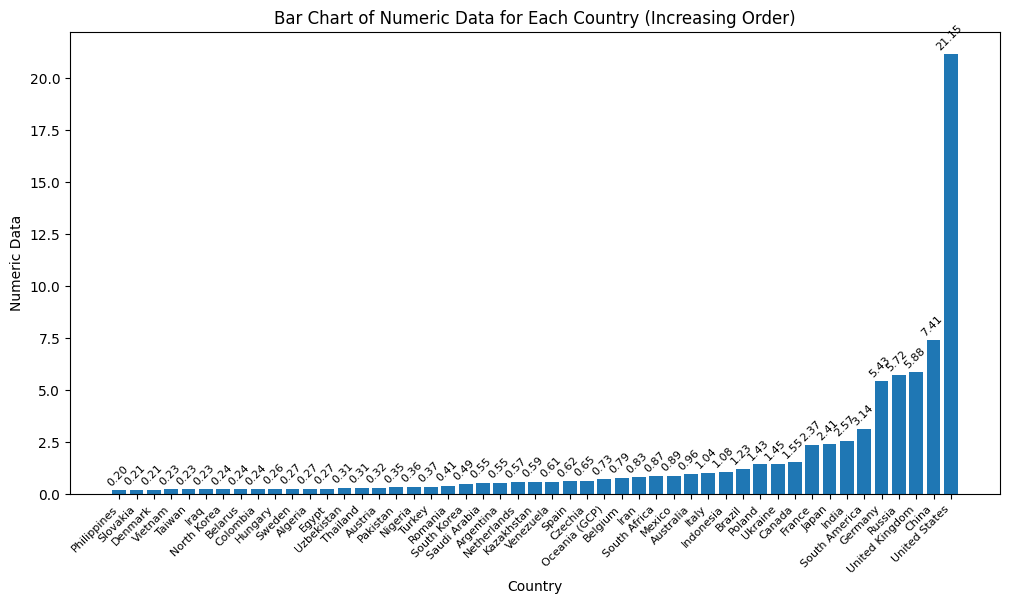

In [151]:
#plot cumualtive RF  data for sanity check
# Sort the dictionary items based on values in ascending order
sorted_data = sorted(crf_2021.items(), key=lambda x: x[1])

# Extract the sorted keys and values
countries, values = zip(*sorted_data)

# Extract the sorted keys and values for the last 50 countries
last_50_countries, last_50_values = zip(*sorted_data[-50:-1])

# Plotting the bar chart
# Set a smaller figure size

plt.figure(figsize=(12, 6))

# Plotting the bar chart
bars = plt.bar(last_50_countries, last_50_values)

# Annotate each bar with its corresponding value
for i, value in enumerate(last_50_values):
    plt.text(bars[i].get_x() + bars[i].get_width() / 2 - 0.1, bars[i].get_height() + 0.1, f'{value:.2f}', ha='center', va='bottom', fontsize=8, rotation=45)

plt.xlabel('Country')
plt.ylabel('Numeric Data')
plt.title('Bar Chart of Numeric Data for Each Country (Increasing Order)')
plt.xticks(rotation=45, ha='right', fontsize = 8)
plt.show()

for predictions

In [ ]:
# Replace 'your_file.csv' with the actual file name
raw_prediction = pd.read_csv('prediction.csv')

# Drop rows where 'year' is smaller than 1800
raw_prediction = raw_prediction[raw_prediction['year'] >= 1800]

# Replace all NaN values with 0
raw_prediction.fillna(0, inplace=True)

newlist = ['Forcast', 'country', 'country2', 'year', 'co2', 'ch4',
       'n2o', 'ch4_e', 'n2o_e',
       'Unnamed: 9']
raw_prediction.columns = newlist
raw_prediction = raw_prediction.drop(columns='Unnamed: 9')

# Specify the columns to add
columns_to_add = ["pre_co2_rf", "pre_ch4_rf", "pre_n2o_rf"]

# Add the specified columns with default values of 0
raw_prediction[columns_to_add] = 0

country_40 = raw_prediction['country'].unique()
#print(country_40)

#make sure that the values in "country2" clolumn are correct. there should only be country + number values
prediction = pd.DataFrame()
for country in country_40:
  base1= raw_prediction[raw_prediction['country2']== country]
  base2 = base1
  for i in range(4):
    base2['country2']=country+str(i+1)
    rowtoadd = raw_prediction[raw_prediction['country2']== country+str(i+1)]
    prediction = prediction.append(base2,ignore_index = True)
    prediction = prediction.append(rowtoadd,ignore_index = True)




In [ ]:
#reorganize the data so that they are ordered by Scenarios
org_pre = pd.DataFrame()
for i in range(4):
  for country in country_40:
    base1=prediction[prediction['country2']==country+str(i+1)]
    org_pre = org_pre.append(base1,ignore_index = True)

org_pre

In [240]:
# Get all unique country names
pre_unique_countries = prediction['country2'].unique()

# Create a dictionary to store CO2 data for each country
pre_co2_data_dict = {}
pre_ch4_data_dict = {}
pre_n2o_data_dict = {}

# Iterate through each country and extract emissions data
for country in pre_unique_countries:

    # Extract emissions data for the current country
    pre_co2_data = prediction[prediction['country2'] == country]['co2'].to_numpy()
    pre_ch4_data = prediction[prediction['country2'] == country]['ch4'].to_numpy()
    pre_n2o_data = prediction[prediction['country2'] == country]['n2o'].to_numpy()

    # Store the emissions data in the dictionary
    pre_co2_data_dict[country] = pre_co2_data
    pre_ch4_data_dict[country] = pre_ch4_data
    pre_n2o_data_dict[country] = pre_n2o_data




In [243]:
co2_rf_column = 9
ch4_rf_column = 10
n2o_rf_column = 11

country_160 = prediction['country2'].unique()
for country in country_160:

  #find data to insert
  to_insert_co2 = pre_calc_co2_rf(pre_co2_data_dict[country])
  to_insert_ch4 = pre_calc_ch4_rf(pre_ch4_data_dict[country])
  to_insert_n2o = pre_calc_n2o_rf(pre_n2o_data_dict[country])

  #get the first appearnce of the country name, so you can insert the data
  start_row_index = (prediction['country2'] == country).idxmax()

  #insert data
  for i in range (to_insert_co2.shape[0]):
    prediction.iloc[start_row_index+i,co2_rf_column] = to_insert_co2[i]
    prediction.iloc[start_row_index+i,ch4_rf_column] = to_insert_ch4[i]
    prediction.iloc[start_row_index+i,n2o_rf_column] = to_insert_n2o[i]



<ipython-input-243-42920184e692>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  org_pre.append(base1,ignore_index = True)


""


In [250]:
#print result to excel
prediction.to_excel('org_prediction.xlsx', index=False)